## Import Libraries

In [91]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

## Load Data

In [92]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/submission.csv')

## EDA

### 기본 데이터 확인

In [93]:
train

,id,digit,letter,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,...,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,...,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,...,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,...,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,...,4,4,3,2,1,3,4,3,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,2044,6,V,2,4,3,4,2,4,4,...,0,2,2,0,0,1,3,1,4,0
2044,2045,1,L,3,2,2,1,1,4,0,...,2,3,4,2,1,2,3,4,1,1
2045,2046,9,A,4,0,4,0,2,4,4,...,2,3,1,1,3,4,2,2,0,0
2046,2047,0,Z,2,3,3,0,3,0,4,...,2,3,1,1,0,4,1,4,3,1


In [94]:
test

,id,letter,0,1,2,3,4,5,6,7,...,774,775,776,777,778,779,780,781,782,783
0,2049,L,0,4,0,2,4,2,3,1,...,2,0,4,2,2,4,3,4,1,4
1,2050,C,4,1,4,0,1,1,0,2,...,0,3,2,4,2,4,2,2,1,2
2,2051,S,0,4,0,1,3,2,3,0,...,1,3,2,0,3,2,3,0,1,4
3,2052,K,2,1,3,3,3,4,3,0,...,3,0,3,2,4,1,0,4,4,4
4,2053,W,1,0,1,1,2,2,1,4,...,4,3,1,4,0,2,1,2,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20475,22524,P,1,2,1,1,0,0,0,2,...,0,1,3,0,3,0,4,3,1,4
20476,22525,S,4,1,1,4,0,0,1,1,...,1,3,1,0,0,1,3,1,2,0
20477,22526,B,4,2,1,3,2,1,3,0,...,3,2,3,4,1,0,3,3,1,1
20478,22527,K,1,1,2,3,4,0,4,3,...,2,0,0,4,3,3,3,4,4,2


In [95]:
pd.value_counts(train['letter'])

Z    91
K    90
O    90
H    89
L    89
G    87
M    86
Y    86
U    85
Q    82
T    82
R    81
F    80
X    79
N    77
S    76
D    76
C    74
V    73
A    72
B    71
W    69
J    67
E    66
P    66
I    64
Name: letter, dtype: int64

## 데이터 시각화

In [96]:
train.shape

(2048, 787)

In [97]:
X_temp = np.array(train[[str(i) for i in range(784)]][:32])
X_temp = X_temp.reshape(-1,1,28,28)
X_temp.shape

(32, 1, 28, 28)

In [98]:
train_digit = train['digit'].values
X_train_letter = train['letter'].values
X_test_letter = test['letter'].values

### 원본 데이터 시각화

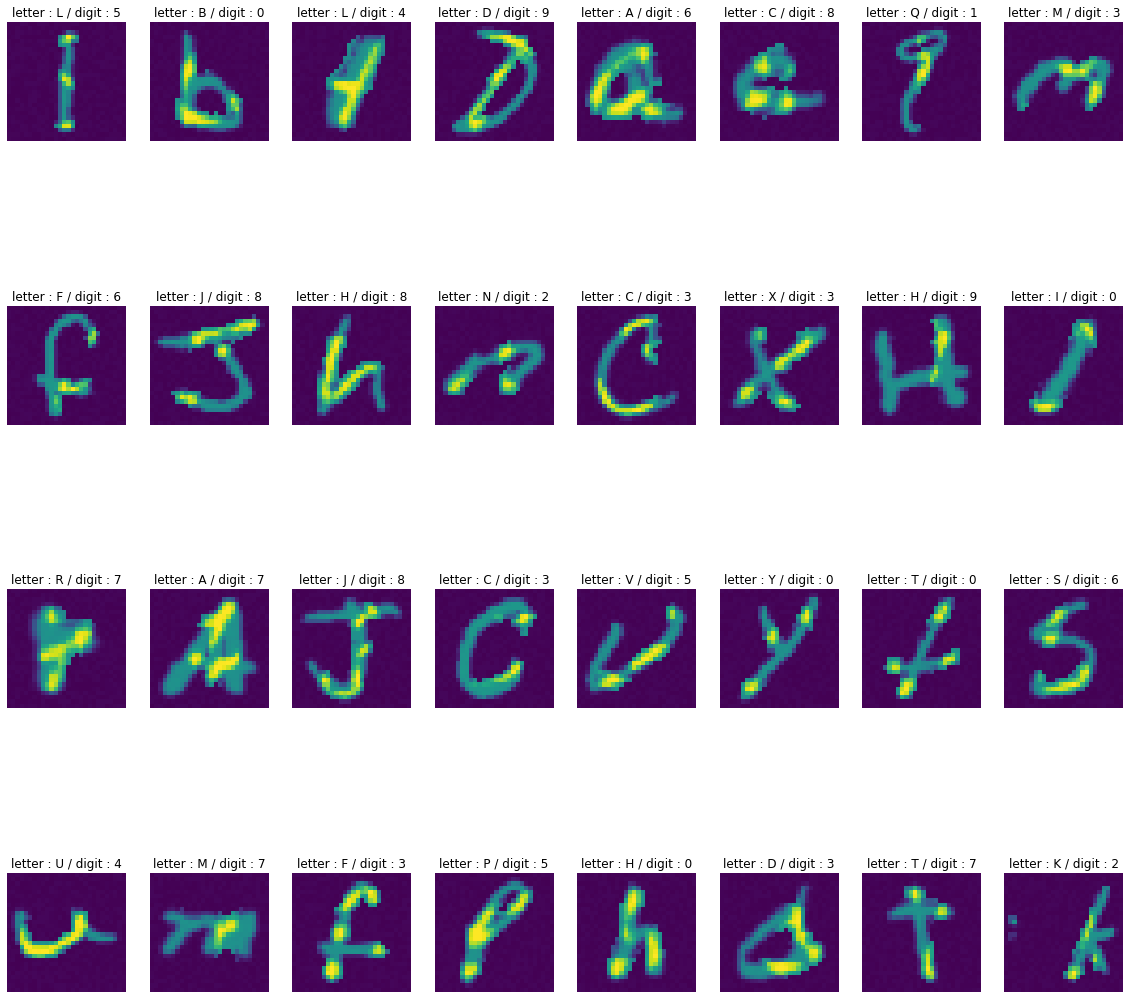

In [99]:
plt.figure(figsize=(20,20))
for idx, (image, digit, letter) in enumerate(zip(X_temp[:32], train_digit[:32] ,X_train_letter[:32])):
    plt.subplot(4,8,idx+1)
    plt.imshow(image[0])
    title = 'letter : {} / digit : {}'.format(letter, digit)
    plt.title(title, fontdict={'color':'black'})
    plt.axis('off')

우리 눈에는 알파벳 모양만 보이고 숫자는 가려져서 잘 보이지 않습니다.  
원본 데이터는 숫자 위에 알파벳 마스크가 덮여져 있는 상태입니다. 

## utility function

뒤에서 사용할 함수를 미리 만들어 줍니다.

### 모델 학습 graph 

In [100]:
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

모델이 학습한 후의 그래프를 보여줍니다.  
정확도와 오차를 보기 쉽게 비교해줍니다.

### alphabet image

In [101]:
def digit_image(x):
    return np.where(x>=150, x, 0)

원본 이미지에서 숫자만 따로 추출하는 함수입니다.  
숫자 전부가 아닌 알파벳 마스크 때문에 가려진 부분은 추출되지 않을 것 입니다.

### alphabet one-hot encoding (사용 안함)

In [102]:
def alpha_one_hot(x):
    label_encoder = LabelEncoder()
    onehot_encoder = OneHotEncoder(sparse=False)
    
    integer_encoded = label_encoder.fit_transform(x)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    
    x = onehot_encoder.fit_transform(integer_encoded)
    return x

## Feature Engineering

In [103]:
X_train = train.drop(['letter','id', 'digit'],axis=1)
TEST = test.drop(['letter','id'],axis=1)
X_trains = X_train.values.reshape(-1,28,28,1)
TEST = TEST.values.reshape(-1,28,28,1)
print(X_trains.shape)
print(TEST.shape)

(2048, 28, 28, 1)
(20480, 28, 28, 1)


In [104]:
X_train = train.drop(['letter','id','digit'],axis=1)
TEST = test.drop(['letter','id'],axis=1)

X_trains = X_train.values.reshape(-1,28,28,1)
TEST = TEST.values.reshape(-1,28,28,1)

print(X_trains.shape)
print(TEST.shape)

(2048, 28, 28, 1)
(20480, 28, 28, 1)


In [105]:
y_trains = train['digit']
y_trains = utils.to_categorical(y_trains, 10)
y_trains.shape

(2048, 10)

원본 데이터는 채널이 1개만 있습니다.  
우리는 이걸 3채널로 바꿀 것 입니다. 

### 숫자만 따로 분리하기

In [106]:
X_train_digit = digit_image(X_trains)
TEST_digit = digit_image(TEST)
X_train_digit.shape

(2048, 28, 28, 1)

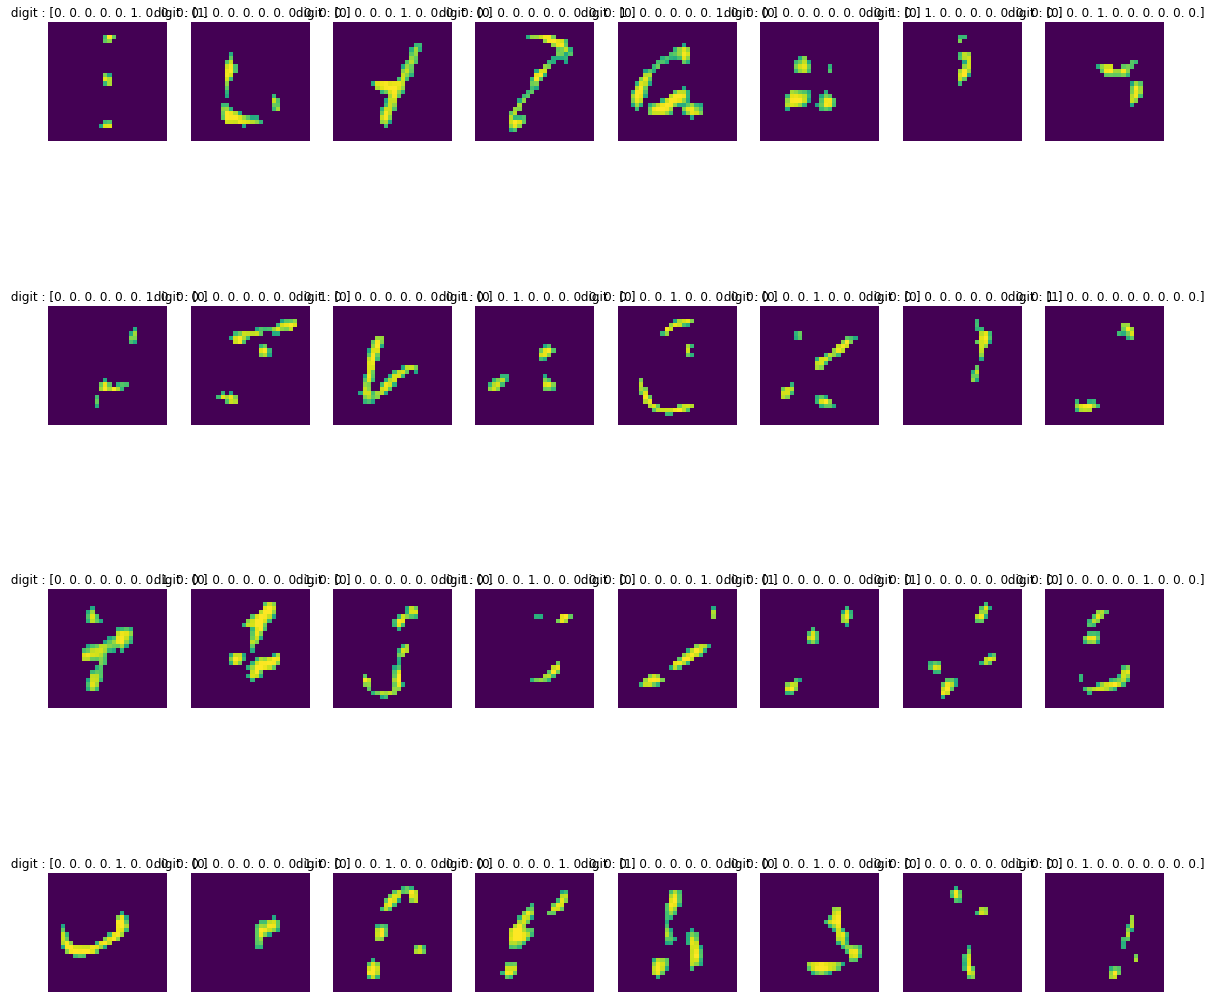

In [107]:
plt.figure(figsize=(20,20))
for idx, digit in enumerate(y_trains[:32]):
    plt.subplot(4,8,idx+1)
    plt.imshow(tf.squeeze(X_train_digit[idx]))
    title = ' digit : {}'.format(digit)
    plt.title(title, fontdict={'color':'black'})
    plt.axis('off')

### 알파벳만 따로 분리하기

In [108]:
X_train_alpha = X_trains - X_train_digit/2
TEST_alpha = TEST - TEST_digit/2

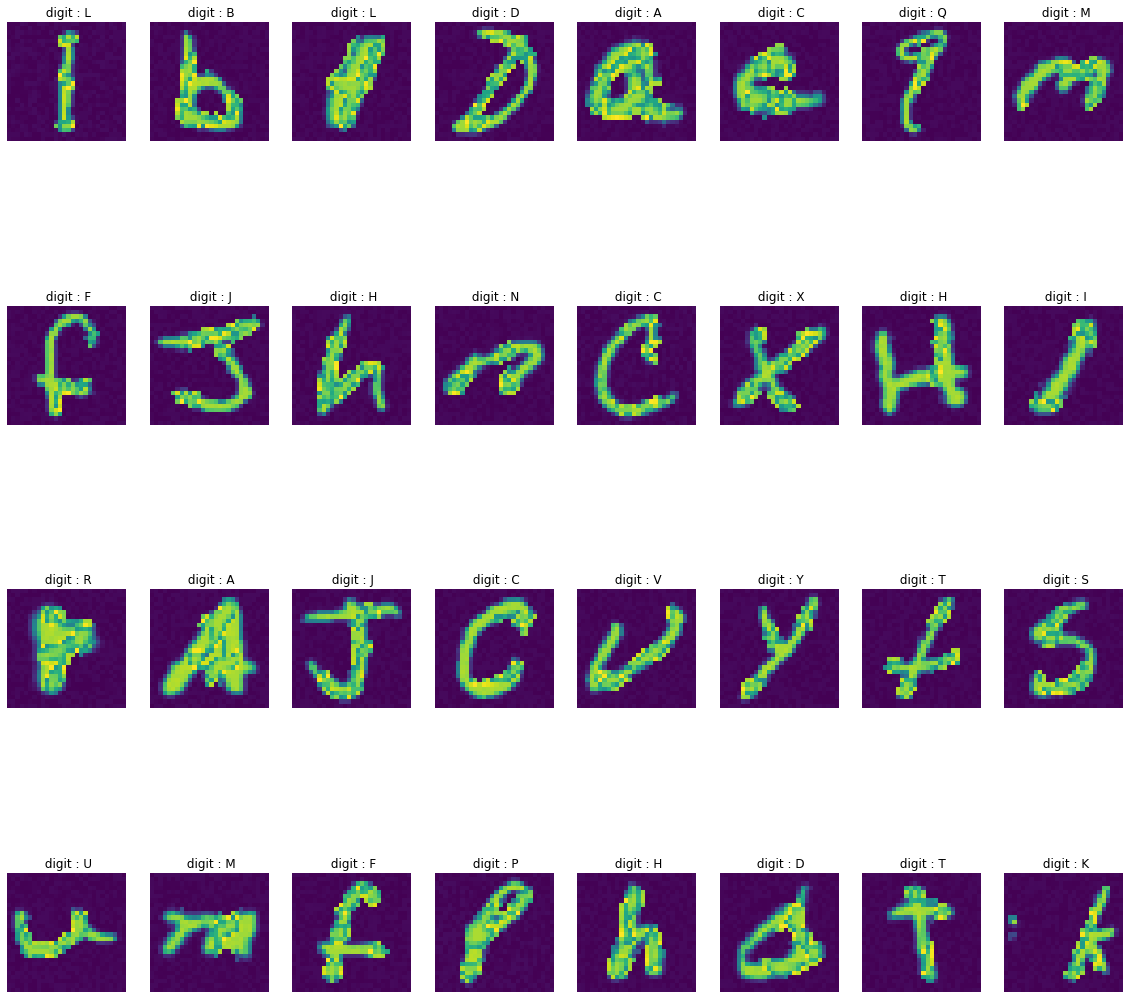

In [109]:
plt.figure(figsize=(20,20))
for idx, letter in enumerate(X_train_letter[:32]):
    plt.subplot(4,8,idx+1)
    plt.imshow(tf.squeeze(X_train_alpha[idx]))
    title = ' digit : {}'.format(letter)
    plt.title(title, fontdict={'color':'black'})
    plt.axis('off')

### 3채널 만들기 (원본, 숫자, 글자)

In [110]:
X_trains = np.concatenate((X_trains, X_train_digit, X_train_alpha),axis=-1)
TEST = np.concatenate((TEST, TEST_digit, TEST_alpha),axis=-1)
print(X_trains.shape)
print(TEST.shape)
print(y_trains.shape)

(2048, 28, 28, 3)
(20480, 28, 28, 3)
(2048, 10)


## Augmentation

In [111]:
# train1 = np.rot90(X_trains, 1, (1,2))
# train2 = np.rot90(X_trains, 2, (1,2))
# train3 = np.rot90(X_trains, 3, (1,2))
# train_lr = np.fliplr(X_trains)
# train_ud = np.flipud(X_trains)

# X_trains = np.vstack([X_trains, train1])
# del train1

# X_trains = np.vstack([X_trains, train2])
# del train2

# X_trains = np.vstack([X_trains, train3])
# del train3

# X_trains = np.vstack([X_trains, train_lr])
# del train_lr

# X_trains = np.vstack([X_trains, train_ud])
# del train_ud

# print(X_trains.shape)

In [112]:
# y = y_trains
# y_trains = np.vstack([y_trains, y])
# y_trains = np.vstack([y_trains, y])
# y_trains = np.vstack([y_trains, y])
# y_trains = np.vstack([y_trains, y])
# y_trains = np.vstack([y_trains, y])
# print(y_trains.shape)

## Train

In [113]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Add, Input, Flatten, Dense, GlobalAveragePooling2D, Dropout, Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [114]:
reduction_ratio=8
axis = 3
groups_size = 8

In [115]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import SeparableConv2D, Input, Conv2D, Add, BatchNormalization, concatenate, AveragePooling2D, add, MaxPooling2D, Conv2DTranspose, Activation, Dropout,UpSampling2D ,ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger


### RexNet

In [116]:
def rexnet_model(shape):
    inputs = Input(shape=(28,28,3))

    conv1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), kernel_initializer='he_normal', activation='elu', padding='same',
                              kernel_constraint=tf.keras.constraints.max_norm(3.))(inputs) #28x28x128


    ## Residual Unit1
    batch1_1 = tf.keras.layers.BatchNormalization()(conv1)
    elu1_1 = tf.keras.layers.ELU()(batch1_1)
    res1_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu1_1) 
    batch1_2 = tf.keras.layers.BatchNormalization()(res1_1)
    elu1_2 = tf.keras.layers.ELU()(batch1_2)
    res1_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu1_2) 
    batch1_3 = tf.keras.layers.BatchNormalization()(res1_2)
    elu1_3 = tf.keras.layers.ELU()(batch1_3)
    res1_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu1_3)                          

    # SEBlock1
    ch_input1 = 128
    ch_reduced1 = ch_input1//reduction_ratio
    avpool1 = tf.keras.layers.GlobalAveragePooling2D()(res1_3)
    sed1_1 = tf.keras.layers.Dense(ch_reduced1, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool1)
    sed1_2 = tf.keras.layers.Dense(ch_input1, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed1_1)
    reshape1 = tf.keras.layers.Reshape((1,1,ch_input1))(sed1_2)
    mul1 = tf.keras.layers.Multiply()([res1_3, reshape1])
    #

    skip1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same')(conv1)
    res1 = tf.keras.layers.Add()([mul1, skip1]) #28x28x128
    ##

    ## Residual Unit2
    batch2_1 = tf.keras.layers.BatchNormalization()(res1)
    elu2_1 = tf.keras.layers.ELU()(batch2_1)
    res2_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu2_1) 
    batch2_2 = tf.keras.layers.BatchNormalization()(res2_1)
    elu2_2 = tf.keras.layers.ELU()(batch2_2)
    res2_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu2_2) 
    batch2_3 = tf.keras.layers.BatchNormalization()(res2_2)
    elu2_3 = tf.keras.layers.ELU()(batch2_3)
    res2_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu2_3)                         


    # SEBlock2
    ch_input2 = 128
    ch_reduced2 = ch_input2//reduction_ratio
    avpool2 = tf.keras.layers.GlobalAveragePooling2D()(res2_3)
    sed2_1 = tf.keras.layers.Dense(ch_reduced2, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool2)
    sed2_2 = tf.keras.layers.Dense(ch_input2, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed2_1)
    reshape2 = tf.keras.layers.Reshape((1,1,ch_input2))(sed2_2)
    mul2 = tf.keras.layers.Multiply()([res2_3, reshape2])
    #
    skip2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same')(res1)
    res2 = tf.keras.layers.Add()([mul2, skip2])
    drop2 = tf.keras.layers.Dropout(0.3)(res2) # 28x28x128
    ##


    ## Residual Unit3
    batch3_1 = tf.keras.layers.BatchNormalization()(drop2)
    elu3_1 = tf.keras.layers.ELU()(batch3_1)
    res3_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu3_1) 
    batch3_2 = tf.keras.layers.BatchNormalization()(res3_1)
    elu3_2 = tf.keras.layers.ELU()(batch3_2)
    res3_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu3_2) 
    batch3_3 = tf.keras.layers.BatchNormalization()(res3_2)
    elu3_3 = tf.keras.layers.ELU()(batch3_3)
    res3_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu3_3)                           


    # SEBlock3
    ch_input3 = 128
    ch_reduced3 = ch_input3//reduction_ratio
    avpool3 = tf.keras.layers.GlobalAveragePooling2D()(res3_3)
    sed3_1 = tf.keras.layers.Dense(ch_reduced3, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool3)
    sed3_2 = tf.keras.layers.Dense(ch_input3, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed3_1)
    reshape3 = tf.keras.layers.Reshape((1,1,ch_input3))(sed3_2)
    mul3 = tf.keras.layers.Multiply()([res3_3, reshape3])
    #
    skip3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1),padding='same')(drop2)
    res3 = tf.keras.layers.Add()([mul3, skip3]) #28x28x128
    ##


    ## Residual Unit4
    batch4_1 = tf.keras.layers.BatchNormalization()(res3)
    elu4_1 = tf.keras.layers.ELU()(batch4_1)
    res4_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu4_1) 
    batch4_2 = tf.keras.layers.BatchNormalization()(res4_1)
    elu4_2 = tf.keras.layers.ELU()(batch4_2)
    res4_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu4_2) 
    batch4_3 = tf.keras.layers.BatchNormalization()(res4_2)
    elu4_3 = tf.keras.layers.ELU()(batch4_3)
    res4_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu4_3)                              


    # SEBlock4
    ch_input4 = 256
    ch_reduced4 = ch_input4//reduction_ratio
    avpool4 = tf.keras.layers.GlobalAveragePooling2D()(res4_3)
    sed4_1 = tf.keras.layers.Dense(ch_reduced4, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool4)
    sed4_2 = tf.keras.layers.Dense(ch_input4, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed4_1)
    reshape4 = tf.keras.layers.Reshape((1,1,ch_input4))(sed4_2)
    mul4 = tf.keras.layers.Multiply()([res4_3, reshape4])
    #
    skip4 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(res3)
    res4 = tf.keras.layers.Add()([mul4, skip4])
    pool4 = tf.keras.layers.MaxPool2D((2,2))(res4)
    drop4 = tf.keras.layers.Dropout(0.3)(pool4) # 14x14x256
    ##


    ## Residual Unit5
    batch5_1 = tf.keras.layers.BatchNormalization()(drop4)
    elu5_1 = tf.keras.layers.ELU()(batch5_1)
    res5_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu5_1) 
    batch5_2 = tf.keras.layers.BatchNormalization()(res5_1)
    elu5_2 = tf.keras.layers.ELU()(batch5_2)
    res5_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu5_2) 
    batch5_3 = tf.keras.layers.BatchNormalization()(res5_2)
    elu5_3 = tf.keras.layers.ELU()(batch5_3)
    res5_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu5_3)                                 


    # SEBlock5
    ch_input5 = 256
    ch_reduced5 = ch_input5//reduction_ratio
    avpool5 = tf.keras.layers.GlobalAveragePooling2D()(res5_3)
    sed5_1 = tf.keras.layers.Dense(ch_reduced5, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool5)
    sed5_2 = tf.keras.layers.Dense(ch_input5, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed5_1)
    reshape5 = tf.keras.layers.Reshape((1,1,ch_input5))(sed5_2)
    mul5 = tf.keras.layers.Multiply()([res5_3, reshape5])
    #
    skip5 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(drop4)
    res5 = tf.keras.layers.Add()([mul5, skip5])
    pool5 = tf.keras.layers.MaxPool2D((2,2))(res5) #7x7x256
    ##


    ## Residual Unit6
    batch6_1 = tf.keras.layers.BatchNormalization()(pool5)
    elu6_1 = tf.keras.layers.ELU()(batch6_1)
    res6_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu6_1) 
    batch6_2 = tf.keras.layers.BatchNormalization()(res6_1)
    elu6_2 = tf.keras.layers.ELU()(batch6_2)
    res6_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu6_2) 
    batch6_3 = tf.keras.layers.BatchNormalization()(res6_2)
    elu6_3 = tf.keras.layers.ELU()(batch6_3)
    res6_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu6_3)
    # SEBlock6
    ch_input6 = 256
    ch_reduced6 = ch_input6//reduction_ratio
    avpool6 = tf.keras.layers.GlobalAveragePooling2D()(res6_3)
    sed6_1 = tf.keras.layers.Dense(ch_reduced6, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool6)
    sed6_2 = tf.keras.layers.Dense(ch_input6, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed6_1)
    reshape6 = tf.keras.layers.Reshape((1,1,ch_input6))(sed6_2)
    mul6 = tf.keras.layers.Multiply()([res6_3, reshape6])
    #
    skip6 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(pool5)
    res6 = tf.keras.layers.Add()([mul6, skip6])
    drop6 = tf.keras.layers.Dropout(0.3)(res6) # 7x7x256
    ##

    ## Residual Unit7
    batch7_1 = tf.keras.layers.BatchNormalization()(drop6)
    elu7_1 = tf.keras.layers.ELU()(batch7_1)
    res7_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu7_1) 
    batch7_2 = tf.keras.layers.BatchNormalization()(res7_1)
    elu7_2 = tf.keras.layers.ELU()(batch7_2)
    res7_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu7_2) 
    batch7_3 = tf.keras.layers.BatchNormalization()(res7_2)
    elu7_3 = tf.keras.layers.ELU()(batch7_3)
    res7_3 = tf.keras.layers.Conv2D(filters=512, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu7_3)
    skip7 = tf.keras.layers.Conv2D(filters=512, kernel_size=(1,1),padding='same')(drop6)
    res7 = tf.keras.layers.Add()([res7_3, skip7])
    pool7 = tf.keras.layers.MaxPool2D((3,3))(res7) 
    
    flatten1 = tf.keras.layers.Flatten()(pool7)
    
    dense1 = tf.keras.layers.Dense(1024, activation='elu', kernel_initializer='he_normal', kernel_constraint=tf.keras.constraints.max_norm(3.))(flatten1)
    
    drop1 = tf.keras.layers.Dropout(0.5)(dense1)
    outputs = tf.keras.layers.Dense(10 ,activation='softmax')(drop1)
    model = Model(inputs=inputs, outputs=outputs)

    return model

### Unet

In [ ]:
# Generate model
def unet_classification(shape, activation='elu', weight=False):
    '''
    activation : relu or elu
    weight : 로드할 모델의 가중치의 여부
    '''
    drop = 0.5
    with strategy.scope():
        unit1 = 64
        unit2 = 128
        unit3 = 256
        unit4 = 512
        unit5 = 1024
        # 28 x 28 x 3
        inputs = Input(shape)
        # 28 x 28 x 64
        inputs = tf.keras.layers.Conv2D(unit1, 5,5, kernel_initializer='he_normal', activation='elu', padding='same',
                              kernel_constraint=tf.keras.constraints.max_norm(3.))(inputs)
        # 56 x 56 x 64
        inputs = UpSampling2D(size=(2,2))(inputs)
        # 56 x 56 x 64
        conv1 = Conv2D(unit1, 3, padding = 'same', kernel_initializer = 'he_normal')(inputs)
        conv1 = BatchNormalization()(conv1)
        conv1 = Activation(activation)(conv1)
        conv1 = Conv2D(unit1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
        conv1 = BatchNormalization()(conv1)
        conv1 = Activation(activation)(conv1)
        # 28 x 28 x 64
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        pool1 = Dropout(drop)(pool1)
        # 28 x 28 x 128
        conv2 = Conv2D(unit2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
        conv2 = BatchNormalization()(conv2)
        conv2 = Activation(activation)(conv2)
        conv2 = Conv2D(unit2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
        conv2 = BatchNormalization()(conv2)
        conv2 = Activation(activation)(conv2)
        # 14 x 14 x 128
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        pool2 = Dropout(drop)(pool2)
        # 14 x 14 x 256
        conv3 = Conv2D(unit3, 3, padding = 'same', kernel_initializer = 'he_normal')(pool2)
        conv3 = BatchNormalization()(conv3)
        conv3 = Activation(activation)(conv3)
        conv3 = Conv2D(unit3, 3, padding = 'same', kernel_initializer = 'he_normal')(conv3)
        conv3 = BatchNormalization()(conv3)
        conv3 = Activation(activation)(conv3)
        # 7 x 7 x 256
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
        pool3 = Dropout(drop)(pool3)
        # 7 x 7 x 512
        conv4 = Conv2D(unit4, 3, padding = 'same', kernel_initializer = 'he_normal')(pool3)
        conv4 = BatchNormalization()(conv4)
        conv4 = Activation(activation)(conv4)
        conv4 = Conv2D(unit4, 3, padding = 'same', kernel_initializer = 'he_normal')(conv4)
        conv4 = BatchNormalization()(conv4)
        conv4 = Activation(activation)(conv4)
        drop4 = Dropout(drop)(conv4)
        # 2 x 2 x 512
        pool4 = MaxPooling2D(pool_size=(3, 3))(drop4)
        pool4 = Dropout(drop)(pool4)
        # 2 x 2 x 1024
        conv5 = Conv2D(unit5, 3, padding = 'same', kernel_initializer = 'he_normal')(pool4)
        conv5 = BatchNormalization()(conv5)
        conv5 = Activation(activation)(conv5)
        conv5 = Conv2D(unit5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
        conv5 = BatchNormalization()(conv5)
        conv5 = Activation(activation)(conv5)
        
        flatten1 = tf.keras.layers.Flatten()(conv5)
        
        dense1 = tf.keras.layers.Dense(1024, activation='elu', kernel_initializer='he_normal', kernel_constraint=tf.keras.constraints.max_norm(3.))(flatten1)
        drop1 = tf.keras.layers.Dropout(0.5)(dense1)
        outputs = tf.keras.layers.Dense(10 ,activation='softmax')(drop1)
        model = Model(inputs=inputs, outputs=outputs)
    return model


### Inception

In [118]:
def inception(shape, LOOP=7):
    unit1 = 64
    unit2 = 128
    unit3 = 256
    unit4 = 512
    unit5 = 1024
    drop = 0.5
    
    inputs = Input(shape)
    activation_ = 'elu'
    
    conv1 = Conv2D(filters=64, kernel_size=(5,5), kernel_initializer='he_normal', activation='elu', padding='same',
                              kernel_constraint=tf.keras.constraints.max_norm(3.))(inputs) #28x28x128
    # 56 x 56 x 64
    conv1 = UpSampling2D(size=(2,2))(conv1)
#     inputs = BatchNormalization()(inputs)
    # 56 x 56 x 64
    conv1 = Conv2D(unit1, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation(activation_)(conv1)
    # 28 x 28 x 64
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(drop)(pool1)
    # 28 x 28 x 128
    conv2 = Conv2D(unit2, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation(activation_)(conv2)
    # 14 x 14 x 128
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(drop)(pool2)
    # 14 x 14 x 256
    conv3 = Conv2D(unit3, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation(activation_)(conv3)
    # 7 x 7 x 256
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(drop)(pool3)
    
    # 7 x 7 x 512
    for i in range(LOOP):
        incep1 = BatchNormalization()(pool3)
        incep1 = Conv2D(unit4, 1, padding='same', activation=activation_)(incep1)

        incep3 = Conv2D(unit4, 1, padding='same', activation=activation_)(incep1)
        incep3 = Conv2D(unit4, 3, padding='same', activation=activation_)(incep3)

        incep5 = Conv2D(unit4, 1, padding='same', activation=activation_)(incep3)
        incep5 = Conv2D(unit4, 3, padding='same', activation=activation_)(incep5)
        incep5 = Conv2D(unit4, 3, padding='same', activation=activation_)(incep5)

        pool1 = AveragePooling2D(
            pool_size=(3, 3), strides=1, padding='same')(incep5)
        pool1 = Conv2D(32, 1, padding='same', activation=activation_)(pool1)

        concat = concatenate([incep1, incep3, incep5, pool1])
        
    # 7 x 7 x 1024
    conv4 = BatchNormalization()(concat)
    conv4 = Conv2D(unit5, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation(activation_)(conv4)
    
    # 2 x 2 x 1024
    pool4 = MaxPooling2D(pool_size=(3, 3))(conv4)
    pool4 = Dropout(drop)(pool4)
    
    flatten1 = tf.keras.layers.Flatten()(pool4)
        
    dense1 = tf.keras.layers.Dense(1024, activation='elu', kernel_initializer='he_normal', kernel_constraint=tf.keras.constraints.max_norm(3.))(flatten1)
    drop1 = tf.keras.layers.Dropout(0.5)(dense1)
    outputs = tf.keras.layers.Dense(10 ,activation='softmax')(drop1)
    model = Model(inputs=inputs, outputs=outputs)

    return model

In [119]:
X_trains.shape

(2048, 28, 28, 3)

In [120]:
y_trains.shape

(2048, 10)

In [121]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    fill_mode='nearest'
)
datagen.fit(X_trains)

In [122]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
SEED = 2020
train, test, train_y, test_y = train_test_split(X_trains, y_trains, test_size=0.025, random_state=SEED)
train = train/255.0
test = test/255.0

In [123]:
# 많은 데이터 셋으로 학습시키기 위해 FOLD를 100으로 설정했습니다. Fold 1 중간에 Stop시켰기에 break 조건을 넣어놨습니다.
def get_stacking(in_model, train, test, train_y, test_y, n_fold = 10, SEED=2020):
    k_fold = KFold(n_splits=n_fold, shuffle=True, random_state=SEED)
    
    epochs = 500
    model_number = 0
    history = []
    batch_size = 32
    val_predict = []
    arm_val_predict = np.array([0]*train.shape[0]*10).reshape(train.shape[0], 10).astype('float64')

    test_predict = []
    arm_test_predict = np.array([0]*TEST.shape[0]*10).reshape(TEST.shape[0], 10).astype('float64')
    
    for train_idx, val_idx in k_fold.split(train, train_y):
        x_train, y_train = train[train_idx], train_y[train_idx]
        x_val, y_val = train[val_idx], train_y[val_idx]
        
        model = in_model(train.shape[1:])
        model.compile(loss="categorical_crossentropy",
                      optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), 
                      metrics=["accuracy"])

        es = EarlyStopping(patience=9, verbose=1)
        mc = ModelCheckpoint(f'model1_best_{model_number}.h5', save_best_only=True, verbose=1)
        rlp = ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.8, min_lr=0.0001)
        
        history = model.fit(datagen.flow(x_train, y_train, shuffle=True, batch_size=batch_size),
                                  epochs=epochs,
                                  validation_data=(x_val, y_val),
                                  verbose=1,
                                  steps_per_epoch=x_train.shape[0] // batch_size,
                                  validation_steps=x_val.shape[0] // batch_size,
                                  callbacks=[es, mc, rlp]
                                  )
        
#         history = model.fit(x_train, y_train, epochs = 53, validation_data=(x_val, y_val), verbose=1, batch_size = batch_size, callbacks = [es, mc, rlp])
        
        plot_curve(history.epoch, history.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])
        
        model.load_weights(f'model1_best_{model_number}.h5')
        pred_train = model.predict(x_val)
        pred_test = model.predict(TEST)
        val_predict.append(pred_train)
        test_predict.append(pred_test)
        
    for pred_train, pred_test in val_predict, test_predict:
        arm_val_predict += val_predict
        arm_test_predict += pred_test
    arm_val_predict = np.argmax(arm_val_predict, axis=1)    
    arm_test_predict = np.argmax(arm_test_predict, axis=1)

    return arm_val_predict, arm_test_predict

## Predict

In [124]:
train.shape

(1996, 28, 28, 3)

Epoch 1/500
56/56 [==============================] - ETA: 0s - loss: 4.7516 - accuracy: 0.1004
Epoch 00001: val_loss improved from inf to 2.46541, saving model to model1_best_0.h5
56/56 [==============================] - 21s 376ms/step - loss: 4.7516 - accuracy: 0.1004 - val_loss: 2.4654 - val_accuracy: 0.0950 - lr: 0.0010
Epoch 2/500
55/56 [============================>.] - ETA: 0s - loss: 2.9436 - accuracy: 0.1259
Epoch 00002: val_loss improved from 2.46541 to 2.45207, saving model to model1_best_0.h5
56/56 [==============================] - 2s 43ms/step - loss: 2.9393 - accuracy: 0.1276 - val_loss: 2.4521 - val_accuracy: 0.1700 - lr: 0.0010
Epoch 3/500
55/56 [============================>.] - ETA: 0s - loss: 2.9712 - accuracy: 0.1236
Epoch 00003: val_loss did not improve from 2.45207
56/56 [==============================] - 2s 37ms/step - loss: 2.9772 - accuracy: 0.1224 - val_loss: 2.5918 - val_accuracy: 0.1350 - lr: 0.0010
Epoch 4/500
55/56 [============================>.] - ETA: 0

Epoch 28/500
55/56 [============================>.] - ETA: 0s - loss: 1.7484 - accuracy: 0.3851
Epoch 00028: val_loss improved from 1.21603 to 1.10890, saving model to model1_best_0.h5
56/56 [==============================] - 2s 43ms/step - loss: 1.7485 - accuracy: 0.3866 - val_loss: 1.1089 - val_accuracy: 0.6550 - lr: 8.0000e-04
Epoch 29/500
56/56 [==============================] - ETA: 0s - loss: 1.6564 - accuracy: 0.4235
Epoch 00029: val_loss did not improve from 1.10890
56/56 [==============================] - 2s 38ms/step - loss: 1.6564 - accuracy: 0.4235 - val_loss: 1.3143 - val_accuracy: 0.5450 - lr: 8.0000e-04
Epoch 30/500
56/56 [==============================] - ETA: 0s - loss: 1.7055 - accuracy: 0.4172
Epoch 00030: val_loss improved from 1.10890 to 1.05428, saving model to model1_best_0.h5
56/56 [==============================] - 2s 43ms/step - loss: 1.7055 - accuracy: 0.4172 - val_loss: 1.0543 - val_accuracy: 0.6700 - lr: 8.0000e-04
Epoch 31/500
55/56 [======================

Epoch 55/500
55/56 [============================>.] - ETA: 0s - loss: 1.1826 - accuracy: 0.5958
Epoch 00055: val_loss did not improve from 0.63247
56/56 [==============================] - 2s 38ms/step - loss: 1.1824 - accuracy: 0.5958 - val_loss: 1.0400 - val_accuracy: 0.7100 - lr: 4.0960e-04
Epoch 56/500
55/56 [============================>.] - ETA: 0s - loss: 1.1272 - accuracy: 0.6178
Epoch 00056: val_loss improved from 0.63247 to 0.63245, saving model to model1_best_0.h5
56/56 [==============================] - 2s 43ms/step - loss: 1.1207 - accuracy: 0.6202 - val_loss: 0.6325 - val_accuracy: 0.8100 - lr: 4.0960e-04
Epoch 57/500
55/56 [============================>.] - ETA: 0s - loss: 1.1432 - accuracy: 0.6028
Epoch 00057: val_loss did not improve from 0.63245
56/56 [==============================] - 2s 39ms/step - loss: 1.1429 - accuracy: 0.6032 - val_loss: 0.6981 - val_accuracy: 0.7950 - lr: 4.0960e-04
Epoch 58/500
55/56 [============================>.] - ETA: 0s - loss: 1.1042 - a

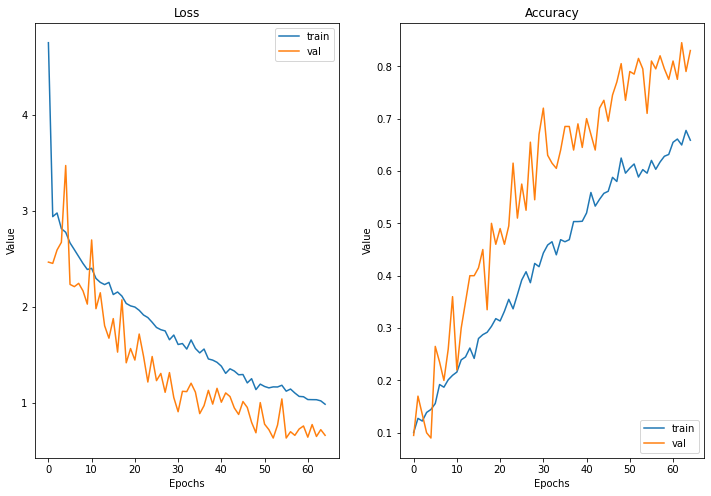

Epoch 1/500
55/56 [============================>.] - ETA: 0s - loss: 5.2532 - accuracy: 0.1074
Epoch 00001: val_loss improved from inf to 2.64397, saving model to model1_best_0.h5
56/56 [==============================] - 3s 50ms/step - loss: 5.2123 - accuracy: 0.1094 - val_loss: 2.6440 - val_accuracy: 0.0800 - lr: 0.0010
Epoch 2/500
55/56 [============================>.] - ETA: 0s - loss: 2.8620 - accuracy: 0.1461
Epoch 00002: val_loss did not improve from 2.64397
56/56 [==============================] - 2s 38ms/step - loss: 2.8644 - accuracy: 0.1463 - val_loss: 3.4447 - val_accuracy: 0.0850 - lr: 0.0010
Epoch 3/500
56/56 [==============================] - ETA: 0s - loss: 2.8771 - accuracy: 0.1457
Epoch 00003: val_loss improved from 2.64397 to 2.37643, saving model to model1_best_0.h5
56/56 [==============================] - 2s 43ms/step - loss: 2.8771 - accuracy: 0.1457 - val_loss: 2.3764 - val_accuracy: 0.1600 - lr: 0.0010
Epoch 4/500
56/56 [==============================] - ETA: 0s 

Epoch 28/500
56/56 [==============================] - ETA: 0s - loss: 1.7602 - accuracy: 0.4031
Epoch 00028: val_loss did not improve from 0.99080
56/56 [==============================] - 2s 38ms/step - loss: 1.7602 - accuracy: 0.4031 - val_loss: 1.1044 - val_accuracy: 0.6250 - lr: 8.0000e-04
Epoch 29/500
55/56 [============================>.] - ETA: 0s - loss: 1.7374 - accuracy: 0.3932
Epoch 00029: val_loss did not improve from 0.99080
56/56 [==============================] - 2s 38ms/step - loss: 1.7347 - accuracy: 0.3917 - val_loss: 1.1641 - val_accuracy: 0.5700 - lr: 8.0000e-04
Epoch 30/500
56/56 [==============================] - ETA: 0s - loss: 1.7333 - accuracy: 0.4093
Epoch 00030: val_loss did not improve from 0.99080
56/56 [==============================] - 2s 38ms/step - loss: 1.7333 - accuracy: 0.4093 - val_loss: 1.0017 - val_accuracy: 0.6400 - lr: 8.0000e-04
Epoch 31/500
56/56 [==============================] - ETA: 0s - loss: 1.6154 - accuracy: 0.4512
Epoch 00031: val_loss 

Epoch 55/500
55/56 [============================>.] - ETA: 0s - loss: 1.1793 - accuracy: 0.6022
Epoch 00055: val_loss did not improve from 0.63027
56/56 [==============================] - 2s 38ms/step - loss: 1.1811 - accuracy: 0.6026 - val_loss: 0.8905 - val_accuracy: 0.7400 - lr: 5.1200e-04
Epoch 56/500
56/56 [==============================] - ETA: 0s - loss: 1.0884 - accuracy: 0.6190
Epoch 00056: val_loss did not improve from 0.63027
56/56 [==============================] - 2s 38ms/step - loss: 1.0884 - accuracy: 0.6190 - val_loss: 0.6883 - val_accuracy: 0.8150 - lr: 4.0960e-04
Epoch 57/500
55/56 [============================>.] - ETA: 0s - loss: 1.0239 - accuracy: 0.6500
Epoch 00057: val_loss did not improve from 0.63027
56/56 [==============================] - 2s 40ms/step - loss: 1.0230 - accuracy: 0.6502 - val_loss: 0.6838 - val_accuracy: 0.7750 - lr: 4.0960e-04
Epoch 58/500
55/56 [============================>.] - ETA: 0s - loss: 1.0466 - accuracy: 0.6381
Epoch 00058: val_loss 

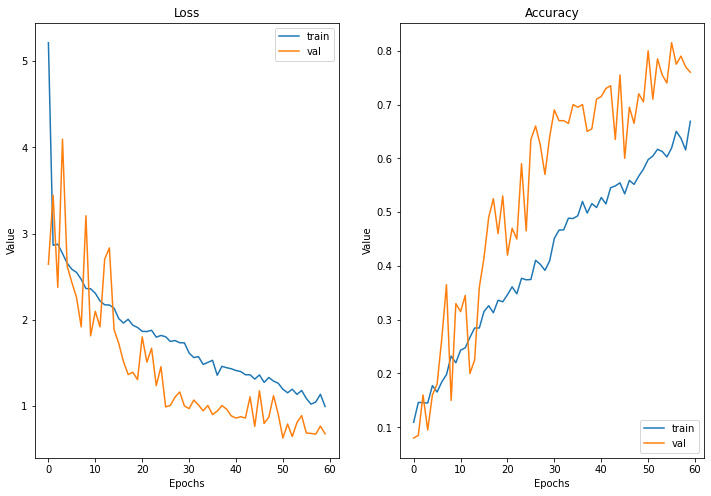

Epoch 1/500
55/56 [============================>.] - ETA: 0s - loss: 4.8720 - accuracy: 0.1193
Epoch 00001: val_loss improved from inf to 2.75403, saving model to model1_best_0.h5
56/56 [==============================] - 3s 49ms/step - loss: 4.8425 - accuracy: 0.1205 - val_loss: 2.7540 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 2/500
55/56 [============================>.] - ETA: 0s - loss: 2.9353 - accuracy: 0.1530
Epoch 00002: val_loss improved from 2.75403 to 2.58685, saving model to model1_best_0.h5
56/56 [==============================] - 2s 43ms/step - loss: 2.9257 - accuracy: 0.1542 - val_loss: 2.5868 - val_accuracy: 0.1700 - lr: 0.0010
Epoch 3/500
55/56 [============================>.] - ETA: 0s - loss: 2.7554 - accuracy: 0.1559
Epoch 00003: val_loss did not improve from 2.58685
56/56 [==============================] - 2s 38ms/step - loss: 2.7611 - accuracy: 0.1559 - val_loss: 3.5664 - val_accuracy: 0.1350 - lr: 0.0010
Epoch 4/500
55/56 [============================>.] - ETA: 0s 

Epoch 28/500
55/56 [============================>.] - ETA: 0s - loss: 1.7890 - accuracy: 0.3834
Epoch 00028: val_loss improved from 1.21688 to 1.18443, saving model to model1_best_0.h5
56/56 [==============================] - 2s 44ms/step - loss: 1.7841 - accuracy: 0.3855 - val_loss: 1.1844 - val_accuracy: 0.5850 - lr: 8.0000e-04
Epoch 29/500
56/56 [==============================] - ETA: 0s - loss: 1.6729 - accuracy: 0.4291
Epoch 00029: val_loss did not improve from 1.18443
56/56 [==============================] - 2s 37ms/step - loss: 1.6729 - accuracy: 0.4291 - val_loss: 1.3090 - val_accuracy: 0.5300 - lr: 8.0000e-04
Epoch 30/500
55/56 [============================>.] - ETA: 0s - loss: 1.6615 - accuracy: 0.4278
Epoch 00030: val_loss did not improve from 1.18443
56/56 [==============================] - 2s 38ms/step - loss: 1.6613 - accuracy: 0.4286 - val_loss: 1.5290 - val_accuracy: 0.4900 - lr: 8.0000e-04
Epoch 31/500
55/56 [============================>.] - ETA: 0s - loss: 1.6211 - a

Epoch 55/500
55/56 [============================>.] - ETA: 0s - loss: 1.1472 - accuracy: 0.5935
Epoch 00055: val_loss did not improve from 0.78222
56/56 [==============================] - 2s 38ms/step - loss: 1.1462 - accuracy: 0.5947 - val_loss: 0.7943 - val_accuracy: 0.7500 - lr: 5.1200e-04
Epoch 56/500
55/56 [============================>.] - ETA: 0s - loss: 1.1591 - accuracy: 0.5982
Epoch 00056: val_loss improved from 0.78222 to 0.76438, saving model to model1_best_0.h5
56/56 [==============================] - 2s 43ms/step - loss: 1.1546 - accuracy: 0.5986 - val_loss: 0.7644 - val_accuracy: 0.7450 - lr: 5.1200e-04
Epoch 57/500
55/56 [============================>.] - ETA: 0s - loss: 1.1062 - accuracy: 0.6250
Epoch 00057: val_loss did not improve from 0.76438
56/56 [==============================] - 2s 38ms/step - loss: 1.1054 - accuracy: 0.6253 - val_loss: 0.9292 - val_accuracy: 0.7150 - lr: 5.1200e-04
Epoch 58/500
55/56 [============================>.] - ETA: 0s - loss: 1.1338 - a

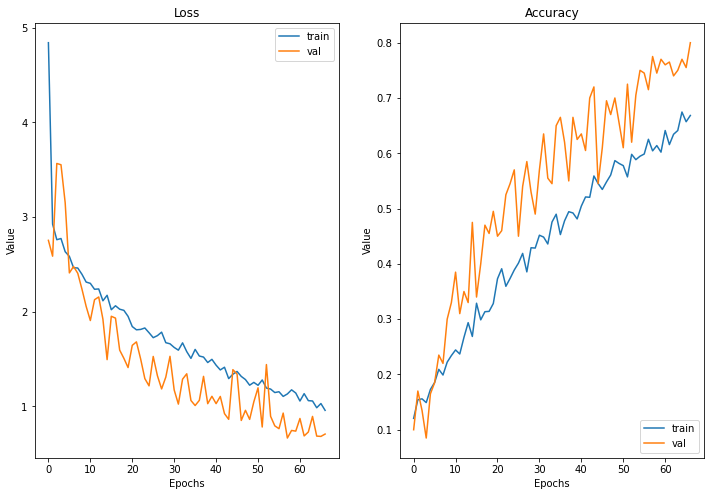

Epoch 1/500
55/56 [============================>.] - ETA: 0s - loss: 5.3672 - accuracy: 0.1170
Epoch 00001: val_loss improved from inf to 2.43654, saving model to model1_best_0.h5
56/56 [==============================] - 3s 50ms/step - loss: 5.3132 - accuracy: 0.1189 - val_loss: 2.4365 - val_accuracy: 0.1950 - lr: 0.0010
Epoch 2/500
55/56 [============================>.] - ETA: 0s - loss: 2.8576 - accuracy: 0.1409
Epoch 00002: val_loss did not improve from 2.43654
56/56 [==============================] - 2s 39ms/step - loss: 2.8577 - accuracy: 0.1400 - val_loss: 2.4671 - val_accuracy: 0.1150 - lr: 0.0010
Epoch 3/500
55/56 [============================>.] - ETA: 0s - loss: 2.7532 - accuracy: 0.1507
Epoch 00003: val_loss improved from 2.43654 to 2.40835, saving model to model1_best_0.h5
56/56 [==============================] - 2s 44ms/step - loss: 2.7495 - accuracy: 0.1525 - val_loss: 2.4084 - val_accuracy: 0.2050 - lr: 0.0010
Epoch 4/500
55/56 [============================>.] - ETA: 0s 

56/56 [==============================] - 2s 42ms/step - loss: 1.6242 - accuracy: 0.4246 - val_loss: 1.1549 - val_accuracy: 0.5850 - lr: 6.4000e-04
Epoch 28/500
55/56 [============================>.] - ETA: 0s - loss: 1.6921 - accuracy: 0.4013
Epoch 00028: val_loss did not improve from 1.15487
56/56 [==============================] - 2s 38ms/step - loss: 1.6916 - accuracy: 0.4002 - val_loss: 1.1880 - val_accuracy: 0.6050 - lr: 6.4000e-04
Epoch 29/500
55/56 [============================>.] - ETA: 0s - loss: 1.6476 - accuracy: 0.4284
Epoch 00029: val_loss improved from 1.15487 to 1.08042, saving model to model1_best_0.h5
56/56 [==============================] - 2s 42ms/step - loss: 1.6468 - accuracy: 0.4291 - val_loss: 1.0804 - val_accuracy: 0.6000 - lr: 6.4000e-04
Epoch 30/500
56/56 [==============================] - ETA: 0s - loss: 1.6107 - accuracy: 0.4484
Epoch 00030: val_loss improved from 1.08042 to 1.06950, saving model to model1_best_0.h5
56/56 [==============================] - 2

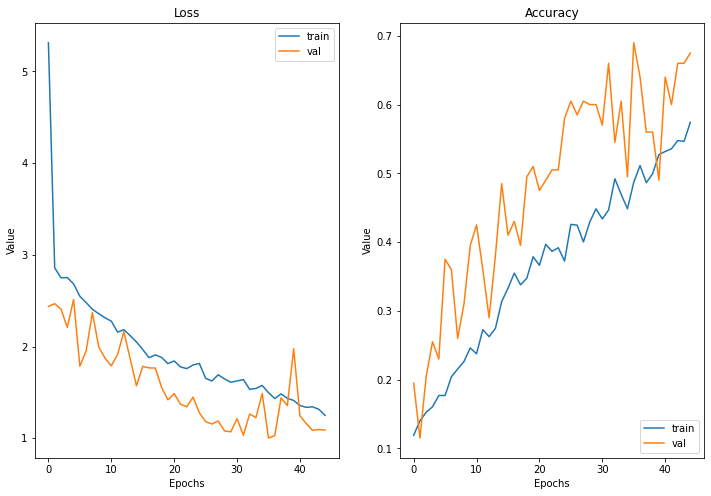

Epoch 1/500
55/56 [============================>.] - ETA: 0s - loss: 5.2133 - accuracy: 0.1125
Epoch 00001: val_loss improved from inf to 2.65775, saving model to model1_best_0.h5
56/56 [==============================] - 3s 50ms/step - loss: 5.1733 - accuracy: 0.1122 - val_loss: 2.6578 - val_accuracy: 0.1200 - lr: 0.0010
Epoch 2/500
55/56 [============================>.] - ETA: 0s - loss: 2.9591 - accuracy: 0.1305
Epoch 00002: val_loss did not improve from 2.65775
56/56 [==============================] - 2s 39ms/step - loss: 2.9541 - accuracy: 0.1321 - val_loss: 3.1841 - val_accuracy: 0.0850 - lr: 0.0010
Epoch 3/500
55/56 [============================>.] - ETA: 0s - loss: 2.8268 - accuracy: 0.1415
Epoch 00003: val_loss did not improve from 2.65775
56/56 [==============================] - 2s 38ms/step - loss: 2.8210 - accuracy: 0.1423 - val_loss: 2.8735 - val_accuracy: 0.0950 - lr: 0.0010
Epoch 4/500
55/56 [============================>.] - ETA: 0s - loss: 2.7687 - accuracy: 0.1513
Epoc

Epoch 28/500
56/56 [==============================] - ETA: 0s - loss: 1.6681 - accuracy: 0.4246
Epoch 00028: val_loss did not improve from 1.25530
56/56 [==============================] - 2s 38ms/step - loss: 1.6681 - accuracy: 0.4246 - val_loss: 1.2836 - val_accuracy: 0.5500 - lr: 6.4000e-04
Epoch 29/500
55/56 [============================>.] - ETA: 0s - loss: 1.6335 - accuracy: 0.4521
Epoch 00029: val_loss improved from 1.25530 to 1.17844, saving model to model1_best_0.h5
56/56 [==============================] - 2s 43ms/step - loss: 1.6341 - accuracy: 0.4507 - val_loss: 1.1784 - val_accuracy: 0.5850 - lr: 6.4000e-04
Epoch 30/500
56/56 [==============================] - ETA: 0s - loss: 1.5865 - accuracy: 0.4507
Epoch 00030: val_loss did not improve from 1.17844
56/56 [==============================] - 2s 38ms/step - loss: 1.5865 - accuracy: 0.4507 - val_loss: 1.2968 - val_accuracy: 0.5550 - lr: 6.4000e-04
Epoch 31/500
55/56 [============================>.] - ETA: 0s - loss: 1.6168 - a

Epoch 55/500
55/56 [============================>.] - ETA: 0s - loss: 1.1307 - accuracy: 0.6057
Epoch 00055: val_loss did not improve from 0.80433
56/56 [==============================] - 2s 39ms/step - loss: 1.1301 - accuracy: 0.6066 - val_loss: 0.8380 - val_accuracy: 0.7250 - lr: 3.2768e-04
Epoch 56/500
56/56 [==============================] - ETA: 0s - loss: 1.1279 - accuracy: 0.6207
Epoch 00056: val_loss did not improve from 0.80433
56/56 [==============================] - 2s 38ms/step - loss: 1.1279 - accuracy: 0.6207 - val_loss: 0.8474 - val_accuracy: 0.7000 - lr: 3.2768e-04
Epoch 57/500
55/56 [============================>.] - ETA: 0s - loss: 1.0819 - accuracy: 0.6307
Epoch 00057: val_loss did not improve from 0.80433
56/56 [==============================] - 2s 38ms/step - loss: 1.0815 - accuracy: 0.6310 - val_loss: 0.9884 - val_accuracy: 0.6550 - lr: 3.2768e-04
Epoch 58/500
55/56 [============================>.] - ETA: 0s - loss: 1.0449 - accuracy: 0.6438
Epoch 00058: val_loss 

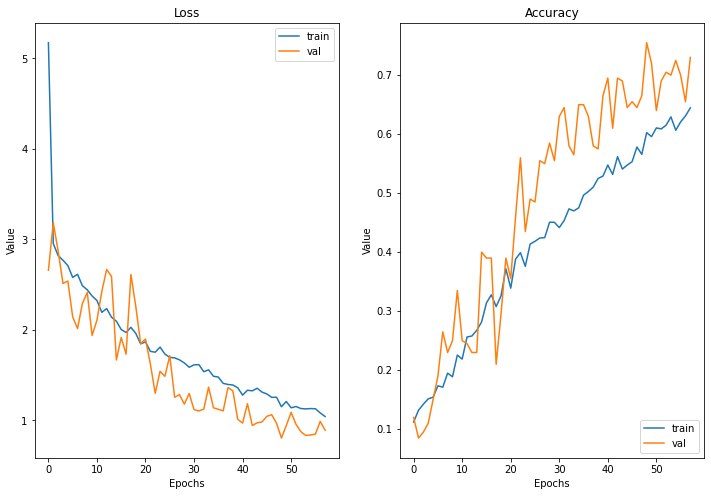

Epoch 1/500
55/56 [============================>.] - ETA: 0s - loss: 4.6556 - accuracy: 0.1153
Epoch 00001: val_loss improved from inf to 2.37529, saving model to model1_best_0.h5
56/56 [==============================] - 3s 50ms/step - loss: 4.6269 - accuracy: 0.1144 - val_loss: 2.3753 - val_accuracy: 0.1800 - lr: 0.0010
Epoch 2/500
55/56 [============================>.] - ETA: 0s - loss: 2.9402 - accuracy: 0.1316
Epoch 00002: val_loss did not improve from 2.37529
56/56 [==============================] - 2s 39ms/step - loss: 2.9414 - accuracy: 0.1315 - val_loss: 3.2960 - val_accuracy: 0.0800 - lr: 0.0010
Epoch 3/500
55/56 [============================>.] - ETA: 0s - loss: 2.9032 - accuracy: 0.1449
Epoch 00003: val_loss did not improve from 2.37529
56/56 [==============================] - 2s 38ms/step - loss: 2.9062 - accuracy: 0.1429 - val_loss: 2.9236 - val_accuracy: 0.1450 - lr: 0.0010
Epoch 4/500
55/56 [============================>.] - ETA: 0s - loss: 2.8239 - accuracy: 0.1501
Epoc

Epoch 28/500
56/56 [==============================] - ETA: 0s - loss: 1.6496 - accuracy: 0.4218
Epoch 00028: val_loss did not improve from 1.31041
56/56 [==============================] - 2s 38ms/step - loss: 1.6496 - accuracy: 0.4218 - val_loss: 1.7124 - val_accuracy: 0.4750 - lr: 4.0960e-04
Epoch 29/500
56/56 [==============================] - ETA: 0s - loss: 1.6100 - accuracy: 0.4490
Epoch 00029: val_loss did not improve from 1.31041
56/56 [==============================] - 2s 38ms/step - loss: 1.6100 - accuracy: 0.4490 - val_loss: 1.5223 - val_accuracy: 0.5300 - lr: 4.0960e-04
Epoch 30/500
55/56 [============================>.] - ETA: 0s - loss: 1.6090 - accuracy: 0.4400
Epoch 00030: val_loss improved from 1.31041 to 1.18475, saving model to model1_best_0.h5
56/56 [==============================] - 2s 41ms/step - loss: 1.6203 - accuracy: 0.4365 - val_loss: 1.1848 - val_accuracy: 0.5600 - lr: 4.0960e-04
Epoch 31/500
56/56 [==============================] - ETA: 0s - loss: 1.5986 - a

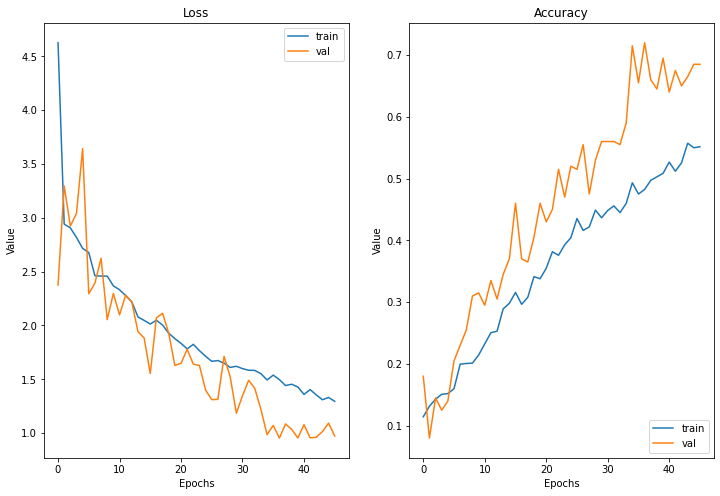

Epoch 1/500
55/56 [============================>.] - ETA: 0s - loss: 4.9325 - accuracy: 0.1034
Epoch 00001: val_loss improved from inf to 2.34420, saving model to model1_best_0.h5
56/56 [==============================] - 23s 415ms/step - loss: 4.8954 - accuracy: 0.1044 - val_loss: 2.3442 - val_accuracy: 0.1709 - lr: 0.0010
Epoch 2/500
56/56 [==============================] - ETA: 0s - loss: 2.9093 - accuracy: 0.1314
Epoch 00002: val_loss did not improve from 2.34420
56/56 [==============================] - 2s 39ms/step - loss: 2.9093 - accuracy: 0.1314 - val_loss: 2.9413 - val_accuracy: 0.1809 - lr: 0.0010
Epoch 3/500
55/56 [============================>.] - ETA: 0s - loss: 2.8455 - accuracy: 0.1431
Epoch 00003: val_loss did not improve from 2.34420
56/56 [==============================] - 2s 39ms/step - loss: 2.8483 - accuracy: 0.1433 - val_loss: 3.8240 - val_accuracy: 0.1307 - lr: 0.0010
Epoch 4/500
56/56 [==============================] - ETA: 0s - loss: 2.7619 - accuracy: 0.1479
Ep

Epoch 28/500
56/56 [==============================] - ETA: 0s - loss: 1.6906 - accuracy: 0.4255
Epoch 00028: val_loss did not improve from 1.06437
56/56 [==============================] - 2s 37ms/step - loss: 1.6906 - accuracy: 0.4255 - val_loss: 1.1114 - val_accuracy: 0.6382 - lr: 8.0000e-04
Epoch 29/500
56/56 [==============================] - ETA: 0s - loss: 1.6677 - accuracy: 0.4238
Epoch 00029: val_loss did not improve from 1.06437
56/56 [==============================] - 2s 38ms/step - loss: 1.6677 - accuracy: 0.4238 - val_loss: 1.2509 - val_accuracy: 0.5930 - lr: 6.4000e-04
Epoch 30/500
56/56 [==============================] - ETA: 0s - loss: 1.5568 - accuracy: 0.4703
Epoch 00030: val_loss did not improve from 1.06437
56/56 [==============================] - 2s 37ms/step - loss: 1.5568 - accuracy: 0.4703 - val_loss: 1.1614 - val_accuracy: 0.6181 - lr: 6.4000e-04
Epoch 31/500
55/56 [============================>.] - ETA: 0s - loss: 1.6176 - accuracy: 0.4547
Epoch 00031: val_loss 

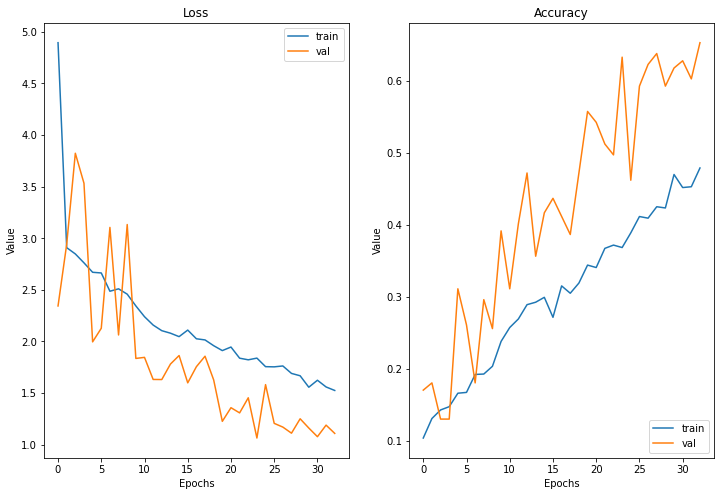

Epoch 1/500
55/56 [============================>.] - ETA: 0s - loss: 5.1787 - accuracy: 0.1102
Epoch 00001: val_loss improved from inf to 2.41314, saving model to model1_best_0.h5
56/56 [==============================] - 3s 48ms/step - loss: 5.1451 - accuracy: 0.1099 - val_loss: 2.4131 - val_accuracy: 0.2010 - lr: 0.0010
Epoch 2/500
55/56 [============================>.] - ETA: 0s - loss: 2.8383 - accuracy: 0.1368
Epoch 00002: val_loss improved from 2.41314 to 2.24423, saving model to model1_best_0.h5
56/56 [==============================] - 2s 41ms/step - loss: 2.8468 - accuracy: 0.1371 - val_loss: 2.2442 - val_accuracy: 0.2261 - lr: 0.0010
Epoch 3/500
55/56 [============================>.] - ETA: 0s - loss: 2.8367 - accuracy: 0.1304
Epoch 00003: val_loss did not improve from 2.24423
56/56 [==============================] - 2s 37ms/step - loss: 2.8436 - accuracy: 0.1303 - val_loss: 3.7619 - val_accuracy: 0.1558 - lr: 0.0010
Epoch 4/500
55/56 [============================>.] - ETA: 0s 

Epoch 28/500
55/56 [============================>.] - ETA: 0s - loss: 1.7111 - accuracy: 0.4028
Epoch 00028: val_loss improved from 1.10181 to 1.07434, saving model to model1_best_0.h5
56/56 [==============================] - 2s 42ms/step - loss: 1.7104 - accuracy: 0.4028 - val_loss: 1.0743 - val_accuracy: 0.6131 - lr: 8.0000e-04
Epoch 29/500
55/56 [============================>.] - ETA: 0s - loss: 1.7397 - accuracy: 0.4010
Epoch 00029: val_loss did not improve from 1.07434
56/56 [==============================] - 2s 38ms/step - loss: 1.7403 - accuracy: 0.4011 - val_loss: 1.1404 - val_accuracy: 0.5578 - lr: 8.0000e-04
Epoch 30/500
55/56 [============================>.] - ETA: 0s - loss: 1.6497 - accuracy: 0.4391
Epoch 00030: val_loss improved from 1.07434 to 1.01145, saving model to model1_best_0.h5
56/56 [==============================] - 2s 42ms/step - loss: 1.6515 - accuracy: 0.4385 - val_loss: 1.0115 - val_accuracy: 0.6080 - lr: 8.0000e-04
Epoch 31/500
56/56 [======================

Epoch 55/500
56/56 [==============================] - ETA: 0s - loss: 1.1152 - accuracy: 0.6255
Epoch 00055: val_loss did not improve from 0.61804
56/56 [==============================] - 2s 38ms/step - loss: 1.1152 - accuracy: 0.6255 - val_loss: 0.7737 - val_accuracy: 0.7538 - lr: 4.0960e-04
Epoch 56/500
56/56 [==============================] - ETA: 0s - loss: 1.0356 - accuracy: 0.6419
Epoch 00056: val_loss did not improve from 0.61804
56/56 [==============================] - 2s 38ms/step - loss: 1.0356 - accuracy: 0.6419 - val_loss: 0.7166 - val_accuracy: 0.7538 - lr: 4.0960e-04
Epoch 57/500
55/56 [============================>.] - ETA: 0s - loss: 1.0618 - accuracy: 0.6460
Epoch 00057: val_loss did not improve from 0.61804
56/56 [==============================] - 2s 38ms/step - loss: 1.0618 - accuracy: 0.6465 - val_loss: 0.7537 - val_accuracy: 0.7638 - lr: 3.2768e-04
Epoch 58/500
55/56 [============================>.] - ETA: 0s - loss: 1.0406 - accuracy: 0.6494
Epoch 00058: val_loss 

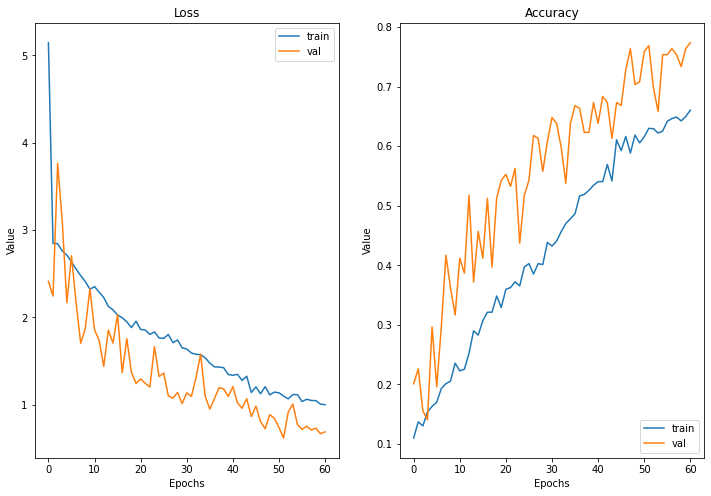

Epoch 1/500
55/56 [============================>.] - ETA: 0s - loss: 5.1807 - accuracy: 0.1006
Epoch 00001: val_loss improved from inf to 2.20570, saving model to model1_best_0.h5
56/56 [==============================] - 3s 51ms/step - loss: 5.1466 - accuracy: 0.1004 - val_loss: 2.2057 - val_accuracy: 0.1859 - lr: 0.0010
Epoch 2/500
55/56 [============================>.] - ETA: 0s - loss: 2.8687 - accuracy: 0.1391
Epoch 00002: val_loss did not improve from 2.20570
56/56 [==============================] - 2s 38ms/step - loss: 2.8719 - accuracy: 0.1394 - val_loss: 6.2965 - val_accuracy: 0.1357 - lr: 0.0010
Epoch 3/500
55/56 [============================>.] - ETA: 0s - loss: 2.8358 - accuracy: 0.1477
Epoch 00003: val_loss did not improve from 2.20570
56/56 [==============================] - 2s 39ms/step - loss: 2.8288 - accuracy: 0.1490 - val_loss: 3.1386 - val_accuracy: 0.1658 - lr: 0.0010
Epoch 4/500
56/56 [==============================] - ETA: 0s - loss: 2.7369 - accuracy: 0.1496
Epoc

Epoch 28/500
56/56 [==============================] - ETA: 0s - loss: 1.6895 - accuracy: 0.4210
Epoch 00028: val_loss did not improve from 1.05365
56/56 [==============================] - 2s 39ms/step - loss: 1.6895 - accuracy: 0.4210 - val_loss: 1.1823 - val_accuracy: 0.6181 - lr: 6.4000e-04
Epoch 29/500
55/56 [============================>.] - ETA: 0s - loss: 1.6707 - accuracy: 0.4201
Epoch 00029: val_loss did not improve from 1.05365
56/56 [==============================] - 2s 39ms/step - loss: 1.6666 - accuracy: 0.4215 - val_loss: 1.2801 - val_accuracy: 0.5829 - lr: 6.4000e-04
Epoch 30/500
55/56 [============================>.] - ETA: 0s - loss: 1.6319 - accuracy: 0.4409
Epoch 00030: val_loss did not improve from 1.05365
56/56 [==============================] - 2s 39ms/step - loss: 1.6279 - accuracy: 0.4436 - val_loss: 1.1090 - val_accuracy: 0.6533 - lr: 6.4000e-04
Epoch 31/500
55/56 [============================>.] - ETA: 0s - loss: 1.6363 - accuracy: 0.4403
Epoch 00031: val_loss 

Epoch 55/500
56/56 [==============================] - ETA: 0s - loss: 1.1796 - accuracy: 0.6006
Epoch 00055: val_loss did not improve from 0.68850
56/56 [==============================] - 2s 38ms/step - loss: 1.1796 - accuracy: 0.6006 - val_loss: 0.9079 - val_accuracy: 0.6935 - lr: 5.1200e-04
Epoch 56/500
56/56 [==============================] - ETA: 0s - loss: 1.1911 - accuracy: 0.5989
Epoch 00056: val_loss did not improve from 0.68850
56/56 [==============================] - 2s 38ms/step - loss: 1.1911 - accuracy: 0.5989 - val_loss: 0.9271 - val_accuracy: 0.6884 - lr: 5.1200e-04
Epoch 57/500
55/56 [============================>.] - ETA: 0s - loss: 1.1527 - accuracy: 0.6028
Epoch 00057: val_loss did not improve from 0.68850
56/56 [==============================] - 2s 38ms/step - loss: 1.1534 - accuracy: 0.6034 - val_loss: 0.9834 - val_accuracy: 0.6935 - lr: 5.1200e-04
Epoch 58/500
55/56 [============================>.] - ETA: 0s - loss: 1.1107 - accuracy: 0.6233
Epoch 00058: val_loss 

55/56 [============================>.] - ETA: 0s - loss: 0.8734 - accuracy: 0.7126
Epoch 00082: val_loss did not improve from 0.44995
56/56 [==============================] - 2s 38ms/step - loss: 0.8735 - accuracy: 0.7116 - val_loss: 0.5428 - val_accuracy: 0.8342 - lr: 2.0972e-04
Epoch 83/500
55/56 [============================>.] - ETA: 0s - loss: 0.8618 - accuracy: 0.7069
Epoch 00083: val_loss did not improve from 0.44995
56/56 [==============================] - 2s 38ms/step - loss: 0.8588 - accuracy: 0.7076 - val_loss: 0.5781 - val_accuracy: 0.8241 - lr: 2.0972e-04
Epoch 84/500
55/56 [============================>.] - ETA: 0s - loss: 0.8033 - accuracy: 0.7271
Epoch 00084: val_loss did not improve from 0.44995
56/56 [==============================] - 2s 38ms/step - loss: 0.7984 - accuracy: 0.7280 - val_loss: 0.5456 - val_accuracy: 0.8141 - lr: 2.0972e-04
Epoch 85/500
55/56 [============================>.] - ETA: 0s - loss: 0.8437 - accuracy: 0.7074
Epoch 00085: val_loss did not impro

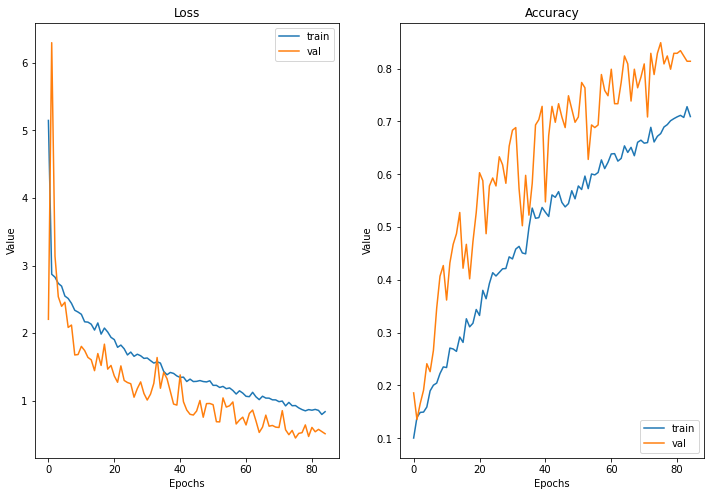

Epoch 1/500
55/56 [============================>.] - ETA: 0s - loss: 4.9900 - accuracy: 0.1080
Epoch 00001: val_loss improved from inf to 2.87702, saving model to model1_best_0.h5
56/56 [==============================] - 3s 49ms/step - loss: 4.9548 - accuracy: 0.1071 - val_loss: 2.8770 - val_accuracy: 0.1307 - lr: 0.0010
Epoch 2/500
55/56 [============================>.] - ETA: 0s - loss: 2.9479 - accuracy: 0.1483
Epoch 00002: val_loss did not improve from 2.87702
56/56 [==============================] - 2s 38ms/step - loss: 2.9482 - accuracy: 0.1473 - val_loss: 3.4408 - val_accuracy: 0.1457 - lr: 0.0010
Epoch 3/500
55/56 [============================>.] - ETA: 0s - loss: 2.7959 - accuracy: 0.1506
Epoch 00003: val_loss improved from 2.87702 to 2.74770, saving model to model1_best_0.h5
56/56 [==============================] - 2s 42ms/step - loss: 2.8005 - accuracy: 0.1484 - val_loss: 2.7477 - val_accuracy: 0.1558 - lr: 0.0010
Epoch 4/500
55/56 [============================>.] - ETA: 0s 

Epoch 28/500
56/56 [==============================] - ETA: 0s - loss: 1.6306 - accuracy: 0.4419
Epoch 00028: val_loss did not improve from 1.02114
56/56 [==============================] - 2s 38ms/step - loss: 1.6306 - accuracy: 0.4419 - val_loss: 1.1161 - val_accuracy: 0.5729 - lr: 8.0000e-04
Epoch 29/500
55/56 [============================>.] - ETA: 0s - loss: 1.6291 - accuracy: 0.4409
Epoch 00029: val_loss did not improve from 1.02114
56/56 [==============================] - 2s 38ms/step - loss: 1.6327 - accuracy: 0.4414 - val_loss: 1.0819 - val_accuracy: 0.6281 - lr: 8.0000e-04
Epoch 30/500
56/56 [==============================] - ETA: 0s - loss: 1.6174 - accuracy: 0.4414
Epoch 00030: val_loss improved from 1.02114 to 1.00535, saving model to model1_best_0.h5
56/56 [==============================] - 2s 42ms/step - loss: 1.6174 - accuracy: 0.4414 - val_loss: 1.0054 - val_accuracy: 0.6332 - lr: 8.0000e-04
Epoch 31/500
55/56 [============================>.] - ETA: 0s - loss: 1.5873 - a

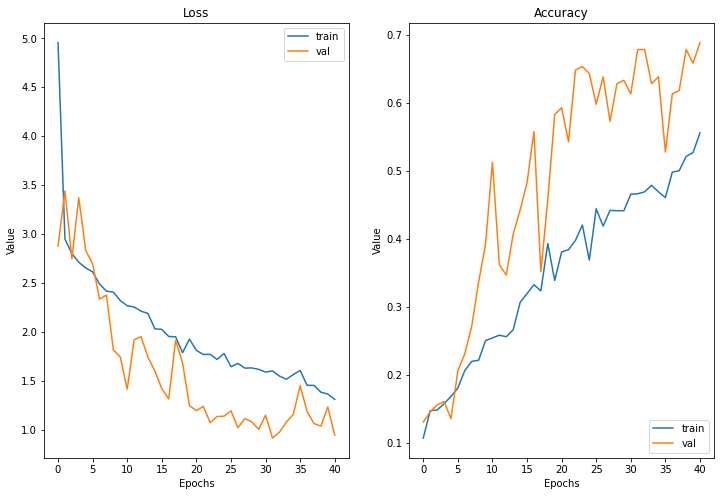

ValueError: too many values to unpack (expected 2)

In [125]:
RX_train, RX_test = get_stacking(rexnet_model, train, test, train_y, test_y)

In [ ]:
IN_train, IN_test = get_stacking(inception, train, test, train_y, test_y)

In [ ]:
UC_train, UC_test = get_stacking(unet_classification, train, test, train_y, test_y)

In [ ]:
X_test = X_test/255.0

In [ ]:
best_model_list = []
for i in range(num_model):
    best = tf.keras.models.load_model('model/channel3_{}.h5'.format(i))
    best_model_list.append(best)

In [ ]:
result_list = []

for idx, model in enumerate(best_model_list):
    result = model.evaluate(X_valid, y_valid)
    print("model_{}_acc : {}".format(idx+1, result))

In [ ]:
pred_list = []
for idx, model in enumerate(best_model_list):
    pred = model.predict(X_test)
    pred_list.append(pred)

In [ ]:
len(pred_list[0][0])

In [ ]:
final_pred = np.array([0]*204800).reshape(20480, 10).astype('float64')
for pred in pred_list:
    final_pred += pred
final_pred = np.argmax(final_pred, axis=1)

In [ ]:
final_pred

In [ ]:
submission['digit'] = final_pred

In [ ]:
submission

In [ ]:
submission.to_csv('./submission/rexnet_ensemble_channel3_submission.csv', index=False)